# Beginning
Importing necessary Python libraries such as NumPy, Pandas, and PyTorch, which are essential for data manipulation, analysis, and building machine learning models.

In [253]:
import numpy as np
import torch
import pandas as pd
import torch.nn.functional as F
from torch.nn import Linear, MSELoss
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATv2Conv, RGCNConv, HeteroConv, GINConv
from torch_geometric.utils.dropout import *

data_folder = "../data/interim/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Manual seeding

In [254]:
import networkx as nx

G = nx.Graph()

np.random.seed(0)
pos = nx.spring_layout(G, seed=0)
torch.manual_seed(0)


# Data
Reading the data from CSV files into Pandas DataFrames.


In [255]:
users = pd.read_csv(data_folder + "users.csv")
items = pd.read_csv(data_folder + "items.csv")
ratings = pd.read_csv(data_folder + "ratings.csv")
genres = pd.read_csv("../data/raw/u.genre", delimiter="|", names=["name", "index"])

In [256]:
src = ratings["user_id"] - 1
dst = ratings["item_id"] - 1
attrs = ratings["rating"]

edge_index = torch.tensor([src, dst], dtype=torch.int64)
edge_attr = torch.tensor(attrs)

Encoding textual data

In [257]:
# Optimized code
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
title_embeddings = model.encode(items["movie_title"], show_progress_bar=True,
                                    convert_to_tensor=True, device=device)

item_title = title_embeddings.to("cpu")
item_genres = torch.tensor(items[genres.name].to_numpy(), dtype=torch.bool)
item_release_year = torch.tensor(items["release_year"].to_numpy()[:, np.newaxis], dtype=torch.int32)

item_x = torch.cat((item_title, item_genres), dim=-1).float()


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

In [258]:
occupations = []
for i in users.keys():
    if i.startswith("occupation_"):
        occupations.append(i)

user_ages = torch.tensor(users["age"].to_numpy()[:, np.newaxis], dtype=torch.uint8)
user_sex = torch.tensor(users[["male", "female"]].to_numpy(), dtype=torch.bool)
user_occupation = torch.tensor(users[occupations].to_numpy(), dtype=torch.bool)
user_x = torch.cat((user_ages, user_sex, user_occupation), dim=-1).float()
data = HeteroData()
data['user'].x = user_x
data['item'].x = item_x
data['user', 'rates', 'item'].edge_index = edge_index
data['user', 'rates', 'item'].edge_label = edge_attr

In [259]:
data = ToUndirected()(data)
del data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
data = data.to(device)
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')],
)(data)

# Define loss function
It was advised to use weighted mse loss

In [260]:
weight = torch.bincount(train_data['user', 'rates', 'item'].edge_label)
weight = weight.max() / weight


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

# Define Model

In [261]:
class GNNEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATv2Conv((-1, -1), 32, add_self_loops=False)
        self.conv2 = GATv2Conv((-1, -1), 32, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['item'][col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder()
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_label_index, mask = dropout_edge(edge_label_index, p=0.25, training=self.training)
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index), mask


# Training and evaluation

In [ ]:
model = Model(hidden_channels=32).to(device)
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [262]:
def train():
    model.train()
    optimizer.zero_grad()
    pred, mask = model(train_data.x_dict, train_data.edge_index_dict,
                       train_data['user', 'rates', 'item'].edge_label_index)
    target = train_data['user', 'rates', 'item'].edge_label
    loss = weighted_mse_loss(pred, target[mask], weight)
    loss.backward()
    optimizer.step()
    return float(loss)


def evaluate(data):
    with torch.no_grad():
        model.eval()
        pred, _ = model(data.x_dict, data.edge_index_dict,
                        data['user', 'rates', 'item'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'rates', 'item'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)

# 500 Epochs
for epoch in range(1, 501):
    loss = train()
    train_rmse = evaluate(train_data)
    val_rmse = evaluate(val_data)
    test_rmse = evaluate(test_data)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train RMSE: {train_rmse:.4f}, '
          f'Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}')

Epoch: 001, Loss: 18.8411, Train RMSE: 3.3074, Val RMSE: 3.3084, Test RMSE: 3.2941
Epoch: 002, Loss: 14.8829, Train RMSE: 2.9632, Val RMSE: 2.9643, Test RMSE: 2.9471
Epoch: 003, Loss: 11.8161, Train RMSE: 2.6264, Val RMSE: 2.6276, Test RMSE: 2.6073
Epoch: 004, Loss: 9.2754, Train RMSE: 2.3193, Val RMSE: 2.3205, Test RMSE: 2.2980
Epoch: 005, Loss: 7.2853, Train RMSE: 2.0626, Val RMSE: 2.0636, Test RMSE: 2.0398
Epoch: 006, Loss: 5.8539, Train RMSE: 1.8207, Val RMSE: 1.8215, Test RMSE: 1.7974
Epoch: 007, Loss: 4.7701, Train RMSE: 1.6002, Val RMSE: 1.6004, Test RMSE: 1.5777
Epoch: 008, Loss: 4.0047, Train RMSE: 1.4113, Val RMSE: 1.4107, Test RMSE: 1.3918
Epoch: 009, Loss: 3.5232, Train RMSE: 1.2689, Val RMSE: 1.2673, Test RMSE: 1.2552
Epoch: 010, Loss: 3.3293, Train RMSE: 1.1840, Val RMSE: 1.1812, Test RMSE: 1.1788
Epoch: 011, Loss: 3.4202, Train RMSE: 1.1549, Val RMSE: 1.1510, Test RMSE: 1.1591
Epoch: 012, Loss: 3.6728, Train RMSE: 1.1649, Val RMSE: 1.1602, Test RMSE: 1.1772
Epoch: 013, L

In [263]:
torch.save(model, "../models/model.pt")

# Make predictions

In [264]:
from tqdm import tqdm

total_users = len(users)
total_movies = len(items)
movie_recs = []
for user_id in tqdm(range(0, total_users)):
    user_row = torch.tensor([user_id] * total_movies)
    all_movie_ids = torch.arange(total_movies)
    edge_label_index = torch.stack([user_row, all_movie_ids], dim=0)
    pred, _ = model(data.x_dict, data.edge_index_dict,
                    edge_label_index)
    rec_movie_ids = (pred > 4.2).nonzero(as_tuple=True)
    top_ten_recs = [{'id': i + 1, 'pred': pred[i].item()} for i in rec_movie_ids[0].tolist()[:20]]
    top_ten_recs.sort(key=lambda x: x['pred'], reverse=True)
    movie_recs.append({'user': user_id + 1, 'rec_movies': top_ten_recs})

100%|██████████| 943/943 [00:03<00:00, 244.13it/s]


In [265]:
movie_recs[0]

{'user': 1,
 'rec_movies': [{'id': 1618, 'pred': 5.3519110679626465},
  {'id': 1653, 'pred': 4.862431049346924},
  {'id': 1299, 'pred': 4.432462215423584},
  {'id': 657, 'pred': 4.429300785064697},
  {'id': 1154, 'pred': 4.412444114685059},
  {'id': 484, 'pred': 4.3768086433410645},
  {'id': 513, 'pred': 4.346354961395264},
  {'id': 653, 'pred': 4.345892906188965},
  {'id': 483, 'pred': 4.34453821182251},
  {'id': 528, 'pred': 4.29091215133667},
  {'id': 1064, 'pred': 4.28092098236084},
  {'id': 427, 'pred': 4.258713245391846},
  {'id': 479, 'pred': 4.245228290557861},
  {'id': 603, 'pred': 4.229416847229004},
  {'id': 1156, 'pred': 4.228713512420654},
  {'id': 478, 'pred': 4.224499702453613},
  {'id': 499, 'pred': 4.222259998321533},
  {'id': 1673, 'pred': 4.2200117111206055},
  {'id': 525, 'pred': 4.2102580070495605},
  {'id': 199, 'pred': 4.200362682342529}]}

# Visualization
Results are visualized as graph of recommendations for a subset

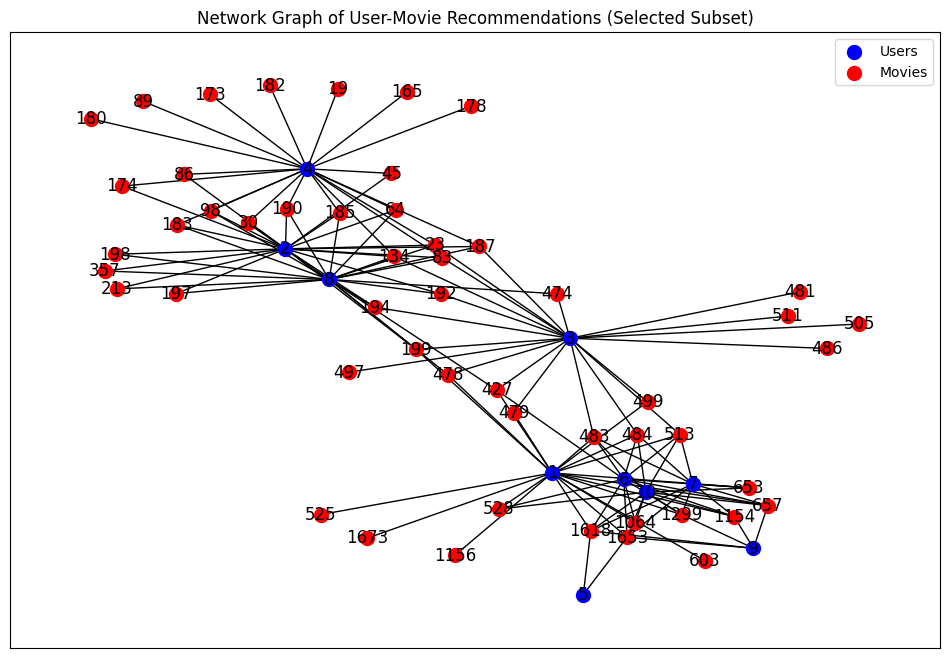

In [271]:
import matplotlib.pyplot as plt
import networkx as nx


# Selecting the first 10 users from the movie_recs data
selected_users = [movie_recs[i]['user'] for i in range(min(10, len(movie_recs)))]

# Collecting the IDs of movies recommended to these users
selected_movies = set()
for user_rec in movie_recs:
    if user_rec['user'] in selected_users:
        selected_movies.update([rec['id'] for rec in user_rec['rec_movies']])

# Convert set to list for consistency
selected_movies = list(selected_movies)

# Constructing the graph with the selected subset
G = nx.Graph()

# Adding nodes for selected users and movies
G.add_nodes_from(selected_users, bipartite=0, label='user')
G.add_nodes_from(selected_movies, bipartite=1, label='movie')

# Adding edges based on actual recommendations for the selected subset
for user_rec in movie_recs:
    if user_rec['user'] in selected_users:
        for rec in user_rec['rec_movies']:
            if rec['id'] in selected_movies:
                G.add_edge(user_rec['user'], rec['id'])

# Plotting the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=selected_users, node_color='blue', node_size=100, label='Users')
nx.draw_networkx_nodes(G, pos, nodelist=selected_movies, node_color='red', node_size=100, label='Movies')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.title('Network Graph of User-Movie Recommendations (Selected Subset)')
plt.legend()
plt.show()
